<a href="https://colab.research.google.com/github/madhes23/deep_learning/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from enum import Enum
import copy

# Importing and plotting samples

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


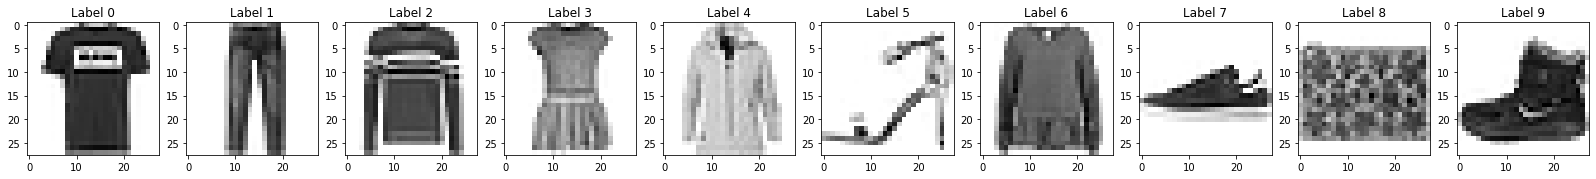

In [3]:
no_of_items = 10

fig, axes = plt.subplots(nrows = 1, ncols=10, figsize = (28, 28))
for item in range(no_of_items):
  index = 0
  while(y_train[index] != item): #searching for the first occurance of the element
    index = index+1
  
  ax = axes[item]
  ax.imshow(x_train[index], cmap='gray_r')
  ax.set_title('Label {}'.format(item))

# Reshaping the data for nerual network


In [4]:
no_of_pixels = x_train[0].size
x_train = x_train.reshape(-1, no_of_pixels)/255
x_test = x_test.reshape(-1, no_of_pixels)/255

# Some Utility functions

In [5]:
class ActivationFunction(Enum):
  SIGMOID = 1
  RELU = 2
  TAN_H = 3

class InitializationMethod(Enum):
  UNIFORM_RANDOM = 1
  UNIFORM_XAVIER = 2
  GAUSSIAN_XAVIER = 3

class OutputFunction(Enum):
  SOFTMAX = 1
  SQUARE_ERROR = 2

class OptimizationAlgorithm(Enum):
  GD = 1
  SGD = 2
  MINI_BATCH = 3
  MOMENTUM_GD = 4
  NAG = 5
  RMS_PROP = 6
  ADAM = 7
  NADAM = 8

class ErrorCalculationMethod(Enum):
  CROSS_ENTROPY = 1
  MEAN_SQUARE_ERROR = 2

def calc_accuracy(predicted, expected):
  return np.sum(predicted == expected) / expected.size

# Main Class

In [6]:
class Classification:
  weight = []
  bias = []
  def __init__(self, _no_of_class, _hidden_layer, _input_layer, _max_epoch, _optimization_algorithm=OptimizationAlgorithm.SGD, _activation_fun=ActivationFunction.RELU, _initialization_method=InitializationMethod.UNIFORM_XAVIER, _output_function = OutputFunction.SOFTMAX, _error_calculation=ErrorCalculationMethod.CROSS_ENTROPY, _learning_rate = 0.01, _batch_size = 32, _momentum = 0.99, _decay_rate_for_update = 0.9) -> None:
    self.no_of_class = _no_of_class
    self.hidden_layer = _hidden_layer
    self.activation_func = _activation_fun
    self.max_epoch = _max_epoch
    self.input_layer = _input_layer
    self.output_func = _output_function
    self.learning_rate = _learning_rate
    self.initialization_method = _initialization_method
    self.error_calculation = _error_calculation
    self.L = len(_hidden_layer) + 1
    self.optimization_algorithm = _optimization_algorithm
    self.batch_size = _batch_size
    self.momentum = _momentum
    self.decay_rate_for_update = _decay_rate_for_update


  def set_weight_and_bias(self):
    #appending all these in a single list (easy for initializing w and b)
    layer = [self.input_layer]
    layer = layer + self.hidden_layer
    layer.append(self.no_of_class)

    #going to use 1-based indexing (as tought in the class)
    #so adding some random matrix in 0-th index
    w = [np.random.rand(1,1)]
    b = [np.random.rand(1,1)]
    prev_w = [np.random.rand(1,1)]
    prev_b = [np.random.rand(1,1)]
    prev_m = [np.random.rand(1,1)]
    if(self.initialization_method == InitializationMethod.UNIFORM_RANDOM): 
      low = -1
      high = 1
      i = 1
      while i < len(layer):
        w.append(np.random.uniform(low, high, size=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))
        prev_w.append(np.zeros(shape=(layer[i], layer[i-1])))
        prev_m.append(np.zeros(shape=(layer[i], layer[i-1])))
        prev_b.append(np.zeros(layer[i]))
        i +=1
    
    if(self.initialization_method == InitializationMethod.UNIFORM_XAVIER): 
      for i in range(1, len(layer)):
        inputs = layer[i-1]
        outputs = layer[i]
        # x = math.sqrt(6/ inputs+outputs)
        x = math.sqrt(1/inputs)
        w.append(np.random.uniform(low=-x, high=x, size=(layer[i], layer[i-1])))
        prev_m.append(np.zeros(shape=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))
        prev_w.append(np.zeros(shape=(layer[i], layer[i-1])))
        prev_b.append(np.zeros(layer[i]))

    if(self.initialization_method == InitializationMethod.GAUSSIAN_XAVIER): 
      mu = 0.0
      for i in range(1, len(layer)):
        inputs = layer[i-1]
        outputs = layer[i]
        # sigma = math.sqrt(6 / inputs+outputs)
        sigma = math.sqrt(1/ inputs)
        w.append(np.random.normal(mu, sigma, size=(layer[i], layer[i-1])))
        prev_m.append(np.zeros(shape=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))
        prev_w.append(np.zeros(shape=(layer[i], layer[i-1])))
        prev_b.append(np.zeros(layer[i]))
    self.weight = w
    self.bias = b
    self.prev_weight = prev_w 
    self.prev_bias = prev_b
    self.prev_moment = prev_m


  def activation_function(self, a):
    if(self.activation_func == ActivationFunction.SIGMOID):   
      # clipping_limit = 400
      # return 1.0 / (1.0 + np.exp(-np.clip(a,-clipping_limit,clipping_limit)))
      new = a.copy()
      new[a<0] = np.exp(a[a<0])/(1.0 + np.exp(a[a<0]))
      new[a>=0] = 1/(1+np.exp(-a[a>=0]))
      return new

    if(self.activation_func == ActivationFunction.RELU):
      return np.maximum(0,a)

    if(self.activation_func == ActivationFunction.TAN_H):
      e_pow_a = np.exp(a)
      e_pow_neg_a = np.exp(-a)
      return (e_pow_a - e_pow_neg_a)/(e_pow_a + e_pow_neg_a)


  def df_activation_function(self, a):
    if(self.activation_func == ActivationFunction.SIGMOID): #sigmoid
      return self.activation_function(a) * (1 - self.activation_function(a))

    if(self.activation_func == ActivationFunction.RELU):
      result = a.copy()
      result[result>=0] = 1
      result[result<0] = 0
      return result
    
    if(self.activation_func == ActivationFunction.TAN_H):
      return 1 - np.square(self.activation_function(a))


  def output_function(self, a):
    if(self.output_func == OutputFunction.SOFTMAX): 
      # a = a - np.max(a)
      # return np.exp(a) / np.sum(np.exp(a), axis=1, keepdims=True)
      num = np.exp(a - ((np.ones(shape=(a.shape[1],a.shape[0]))* (np.max(a,axis=1))).transpose()))
      den = ((np.ones(shape=(a.shape[1],a.shape[0]))* (1/(np.sum(num,axis=1)))).transpose())
      return np.multiply(num,den)


  def calc_total_error(self, predicted_distribution, true_label):
    if(self.error_calculation == ErrorCalculationMethod.CROSS_ENTROPY):
      rows = np.arange(true_label.shape[0]) #setting row number from 0 to length(true label)
      cols = true_label
      predicted_distribution = predicted_distribution[rows,cols]
      predicted_distribution[predicted_distribution == 0] = 1e-6 #setting 0 values to very small value, so we dont get inf 
      return sum(-np.log(predicted_distribution)) 


  def forward_propogation(self, input_images):
    #for using 1 based indexing, adding some random matrix in 0-th index
    a = [np.random.rand(1,1)]
    h = [input_images]

    for i in range(1, self.L):
      a.append(self.bias[i] + np.dot(h[i-1], self.weight[i].T))
      h.append(self.activation_function(a[i]))

    a.append(self.bias[self.L] + np.dot(h[self.L-1], self.weight[self.L].T))
    h.append(self.output_function(a[-1]))
    return a, h


  def backward_propogation(self, a, h, true_label, weight = None):
    if(weight == None):
      weight = self.weight

    del_a = [None] * (self.L+1)
    del_h = [None] * (self.L+1)
    del_w = [None] * (self.L+1)
    del_b = [None] * (self.L+1)
    
    #computing del_a_l
    del_a[-1] = h[-1].copy()
    row_ind = np.arange(true_label.shape[0]) #creating numbers 0 to batch size (for row indices)
    del_a[-1][row_ind,true_label] -= 1

    for k in range(self.L, 0, -1):
      #computing gradients w.r.t parameters
      del_w[k] = np.dot(del_a[k].T, h[k-1])
      del_b[k] = np.sum(del_a[k], axis=0)

      #computing gradients w.r.t layer below (post-activation)
      del_h[k-1] = np.dot(del_a[k],weight[k])

      #computing gradients w.r.t layer below (pre-activation)
      del_a[k-1] = del_h[k-1] * self.df_activation_function(a[k-1])
    
    #setting the 0-th index to some random array of (1,1)
    #so that it won't cause dimention mismatch
    del_w[0] = np.random.rand(1,1)
    del_b[0] = np.random.rand(1,1)
    return del_w, del_b


  def fit(self, x_train, y_train): 
    self.data_size = x_train.shape[0]
    error_list = []
    if(self.optimization_algorithm == OptimizationAlgorithm.GD):
      for i in range(self.max_epoch):
        a, h = self.forward_propogation(x_train)
        del_w, del_b = self.backward_propogation(a, h, y_train) 
        if(i in [0, 10, 50, 100, 200, 400]):
          print("{} th iteration".format(i))
          print("del w", del_w)
          print("del b", del_b)

        #converting to ndarray for easier calculations
        del_w = np.array(del_w, dtype=object)
        del_b = np.array(del_b, dtype=object)
        if(self.activation_func == ActivationFunction.RELU):
          #dividing by the batch size
          del_w /= self.data_size
          del_b /= self.data_size
        if(i in [0, 10, 50, 100, 200, 400]):
          print("type of weight ", type(self.weight))
          print("type of bias ", type(self.bias))
        self.weight -= self.learning_rate * del_w
        self.bias -= self.learning_rate * del_b
        err = self.calc_total_error(h[-1], y_train) / self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.MINI_BATCH):
      no_of_batches = self.data_size // self.batch_size
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1): 
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size

          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          #converting to ndarray for easier calculations
          del_w = np.array(del_w, dtype=object)
          del_b = np.array(del_b, dtype=object)
          self.weight -= self.learning_rate * del_w
          self.bias -= self.learning_rate * del_b
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.SGD): #same as above code, but with batch size = 1
      self.batch_size = 1
      no_of_batches = self.data_size // self.batch_size
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1): 
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size

          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          #converting to ndarray for easier calculations
          del_w = np.array(del_w, dtype=object) / self.batch_size
          del_b = np.array(del_b, dtype=object) / self.batch_size
          self.weight -= self.learning_rate * del_w
          self.bias -= self.learning_rate * del_b
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.MOMENTUM_GD):
      no_of_batches = self.data_size // self.batch_size

      #converting to ndarray for faster calculation ( #todo: why not return it as ndarray )
      prev_w = np.array(self.prev_weight, dtype=object)
      prev_b = np.array(self.prev_bias, dtype=object)
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          #converting to ndarray for easier calculations
          del_w = np.array(del_w, dtype=object)
          del_b = np.array(del_b, dtype=object)
          prev_w = self.momentum * prev_w + (1 - self.momentum) * del_w
          prev_b = self.momentum * prev_b + (1 - self.momentum) * del_b

          self.weight -= self.learning_rate * prev_w
          self.bias -= self.learning_rate * prev_b
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))

    if(self.optimization_algorithm == OptimizationAlgorithm.NAG):
      no_of_batches = self.data_size // self.batch_size

      #converting to ndarray for faster calculation ( #todo: why not return it as ndarray )
      prev_w = np.array(self.prev_weight, dtype=object)
      prev_b = np.array(self.prev_bias, dtype=object)
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          w_lookahead = self.weight - self.momentum * prev_w
          del_w_lookahead, del_b = self.backward_propogation(a, h, y_train[begin:end],weight=w_lookahead)

          #converting to ndarray for easier calculations
          del_w_lookahead = np.array(del_w_lookahead, dtype=object)
          del_b = np.array(del_b, dtype=object)
          prev_w = self.momentum * prev_w + (1 - self.momentum) * del_w_lookahead
          prev_b = self.momentum * prev_b + (1 - self.momentum) * del_b

          self.weight -= self.learning_rate * prev_w
          self.bias -= self.learning_rate * prev_b
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))

    if(self.optimization_algorithm == OptimizationAlgorithm.RMS_PROP):
      no_of_batches = self.data_size // self.batch_size
      eta = 1e-7 #a very small constant 

      #converting to ndarray for faster calculation ( #todo: why not return it as ndarray )
      prev_w = np.array(self.prev_weight, dtype=object)
      prev_b = np.array(self.prev_bias, dtype=object)
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          #converting to ndarray for easier calculations
          del_w = np.array(del_w, dtype=object)
          del_b = np.array(del_b, dtype=object)

          prev_w = self.momentum * prev_w + (1 - self.momentum) * np.square(del_w)
          prev_b = self.momentum * prev_b + (1 - self.momentum) * np.square(del_b)

          new_lr_w = self.learning_rate / (prev_w**0.5 + eta)
          new_lr_b = self.learning_rate / (prev_b**0.5 + eta)

          self.weight -= new_lr_w * del_w
          self.bias -= new_lr_b * del_b
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))
    
    if(self.optimization_algorithm == OptimizationAlgorithm.ADAM):
      no_of_batches = self.data_size // self.batch_size
      eta = 1e-8 #a very small constant 

      #converting to ndarray for faster calculation ( #todo: why not return it as ndarray )
      prev_w = np.array(self.prev_weight, dtype=object)
      prev_b = np.array(self.prev_bias, dtype=object)
      prev_update_w = prev_w.copy()
      prev_update_b = prev_b.copy()
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          #converting to ndarray for easier calculations
          del_w = np.array(del_w, dtype=object)
          del_b = np.array(del_b, dtype=object)

          prev_w = self.momentum * prev_w + (1 - self.momentum) * del_w
          prev_w_hat = prev_w / (1 - self.momentum)
          prev_b = self.momentum * prev_b + (1 - self.momentum) * del_b
          prev_b_hat = prev_b / (1 - self.momentum)

          prev_update_w = self.momentum * prev_update_w + (1 - self.momentum) * np.square(del_w)
          prev_update_m_hat = prev_update_w / (1 - self.momentum)
          prev_update_b = self.momentum * prev_update_b + (1 - self.momentum) * np.square(del_b)
          prev_update_b_hat = prev_update_b / (1 - self.momentum)

          new_lr_w = self.learning_rate / (prev_update_m_hat**0.5 + eta)
          new_lr_b = self.learning_rate / (prev_update_b_hat**0.5 + eta)

          self.weight -= new_lr_w * prev_w_hat
          self.bias -= new_lr_b * prev_b_hat
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))
      
    if(self.optimization_algorithm == OptimizationAlgorithm.NADAM):
      no_of_batches = self.data_size // self.batch_size
      eta = 1e-8 #a very small constant 

      #converting to ndarray for faster calculation ( #todo: why not return it as ndarray )
      prev_w = np.array(self.prev_weight, dtype=object)
      prev_b = np.array(self.prev_bias, dtype=object)
      prev_update_w = prev_w.copy()
      prev_update_b = prev_b.copy()
      for i in range(self.max_epoch):
        err = 0
        for j in range(no_of_batches+1):
          begin = j * self.batch_size
          end = begin + self.batch_size
          if(end > self.data_size):
            end = self.data_size
          
          a, h = self.forward_propogation(x_train[begin:end])
          del_w, del_b = self.backward_propogation(a, h, y_train[begin:end])

          #converting to ndarray for easier calculations
          del_w = np.array(del_w, dtype=object)
          del_b = np.array(del_b, dtype=object)

          prev_w = self.momentum * prev_w + (1 - self.momentum) * del_w
          prev_w_hat = prev_w / (1 - self.momentum)
          prev_b = self.momentum * prev_b + (1 - self.momentum) * del_b
          prev_b_hat = prev_b / (1 - self.momentum)

          prev_update_w = self.momentum * prev_update_w + (1 - self.momentum) * np.square(del_w)
          prev_update_m_hat = prev_update_w / (1 - self.momentum)
          prev_update_b = self.momentum * prev_update_b + (1 - self.momentum) * np.square(del_b)
          prev_update_b_hat = prev_update_b / (1 - self.momentum)

          new_lr_w = self.learning_rate / (prev_update_m_hat**0.5 + eta)
          new_lr_b = self.learning_rate / (prev_update_b_hat**0.5 + eta)

          print("tyrpe of WEIGHT", type(self.weight))
          print("tyrpe of BAIS", type(self.bias))
          self.weight -= new_lr_w * (self.momentum * prev_w_hat + (((1/self.momentum) * del_w) / (1-self.momentum)))
          self.bias -= new_lr_b * (self.momentum * prev_b_hat + (((1/self.momentum) * del_b) / (1-self.momentum)))
          err += self.calc_total_error(h[-1], y_train[begin:end])
        err /= self.data_size
        error_list.append(err)
        print("Completed epoch : {} \t Error: {}".format(i, err))

    
    plt.plot(error_list)
    plt.show()

        

  def test(self, x_test, y_test):
    print("x_test {} \t y_test {}".format(x_test.shape, y_test.shape))
    _ , h = self.forward_propogation(x_test)
    predicted_distribution = h[-1]
    return calc_accuracy(np.argmax(predicted_distribution, axis=1), y_test)

# Models

In [ ]:
#@title ReLU GD Small Data { vertical-output: true}
model1 = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.001,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.NADAM,
                       _batch_size = 32,
                       _momentum = 0.9,
                       _decay_rate_for_update = 0.999,
                       _max_epoch=40)
model1.set_weight_and_bias()


model1.fit(x_train, y_train)

tyrpe of WEIGHT <class 'list'>
tyrpe of BAIS <class 'list'>


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [ ]:
model1.test(x_test, y_test)

x_test (10000, 784) 	 y_test (10000,)


0.7893

In [ ]:
#@title Sigmoid SDG Large data{vertical-output:true}
model = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.SGD,
                       _batch_size = 100,
                       _max_epoch=15)

model.set_weight_and_bias()

model.fit(x_train[:10000], y_train[:10000])


0 th iteration
del w [array([[0.12894592]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.87236639e-06,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.46070373e-05,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.66112657e-04,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.40578052e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.17708988e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.20983755e-04,  0.00000000e+00,  0.00000000e+00]]), array([[ 0.00585668,  0.0096334 ,  0.00999839, ...,  0.01661499,
         0.01927614,  0.01743713],
       [-0.05264448, -0.05963231, -0.06343366, ..., -0.0765346 ,
        -0.07688269, -0.06857054

<ipython-input-6-aff929e60753>:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weight -= self.learning_rate * del_w
<ipython-input-6-aff929e60753>:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.bias -= self.learning_rate * del_b



Completed epoch : 52 	 Error: 1.692607337381073
Completed epoch : 53 	 Error: 1.6915156887928764
Completed epoch : 54 	 Error: 1.6904329652239518
Completed epoch : 55 	 Error: 1.689358062177528
Completed epoch : 56 	 Error: 1.6882899318146745
Completed epoch : 57 	 Error: 1.6872275777718566
Completed epoch : 58 	 Error: 1.686170050470863
Completed epoch : 59 	 Error: 1.6851164428655725
Completed epoch : 60 	 Error: 1.6840658865769753
Completed epoch : 61 	 Error: 1.6830175483738927
Completed epoch : 62 	 Error: 1.6819706269620223
Completed epoch : 63 	 Error: 1.6809243500484228
Completed epoch : 64 	 Error: 1.6798779716524606
Completed epoch : 65 	 Error: 1.6788307696375981
Completed epoch : 66 	 Error: 1.6777820434413837
Completed epoch : 67 	 Error: 1.6767311119835469
Completed epoch : 68 	 Error: 1.675677311734369
Completed epoch : 69 	 Error: 1.6746199949274618
Completed epoch : 70 	 Error: 1.6735585279028293
Completed epoch : 71 	 Error: 1.6724922895675907
Completed epoch : 72 	 

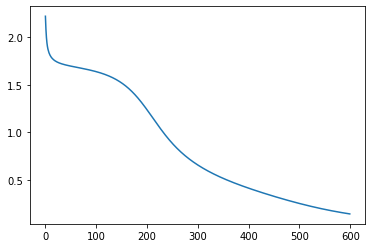

In [7]:
#@title Sigmoid GD Small data{ vertical-output: true}
model1 = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.GD,
                       _max_epoch=600)
model1.set_weight_and_bias()

model1.fit(x_train[:10], y_train[:10])

In [ ]:
#@title Sigmoid Momentum Whole data{vertical-output:true}
model3 = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.MOMENTUM_GD,
                       _batch_size = 50,
                       _momentum = 0.9,
                       _max_epoch=80)

model3.set_weight_and_bias()

model3.fit(x_train, y_train)


In [ ]:
#@title Sigmoid NAG Whole data{vertical-output:true}
model4 = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.NAG,
                       _batch_size = 50,
                       _momentum = 0.9,
                       _max_epoch=80)

model4.set_weight_and_bias()

model4.fit(x_train, y_train)

In [ ]:
#@title Sigmoid SGD whole data{ vertical-output: true}
model5 = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.SGD,
                       _max_epoch=10)
model5.set_weight_and_bias()

model5.fit(x_train, y_train)

<ipython-input-110-bc738ba63d71>:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weight -= new_lr_w * del_w
<ipython-input-110-bc738ba63d71>:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.bias -= new_lr_b * del_b


Completed epoch : 0 	 Error: 0.9237265999284755
Completed epoch : 1 	 Error: 0.7250238375980057
Completed epoch : 2 	 Error: 0.6892174484882004
Completed epoch : 3 	 Error: 0.6751312273186686
Completed epoch : 4 	 Error: 0.6546716767707618
Completed epoch : 5 	 Error: 0.6681998486120238
Completed epoch : 6 	 Error: 0.6512067302496721
Completed epoch : 7 	 Error: 0.6458733169392257
Completed epoch : 8 	 Error: 0.6546229436790653
Completed epoch : 9 	 Error: 0.6537052775383998


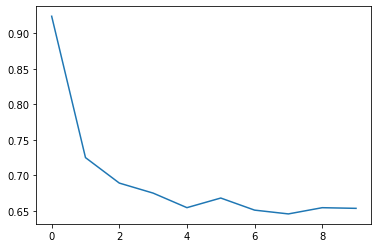

In [ ]:
#@title Sigmoid RMS whole data{ vertical-output: true}
model6 = Classification(_no_of_class=10, 
                       _hidden_layer=[32, 32], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.1,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _optimization_algorithm=OptimizationAlgorithm.RMS_PROP,
                       _batch_size = 100,
                       _momentum = 0.9,
                       _max_epoch=10)
model6.set_weight_and_bias()

model6.fit(x_train, y_train)

In [ ]:
model6.test(x_test,y_test)

x_test (10000, 784) 	 y_test (10000,)


0.8533